# Detect instances of item sharing
Written by Grace Deng, edited by Natalia Velez<br/>
May 2021

This is a branch of `parse_map_changes` for now!

In [1]:
%matplotlib inline

import json, pymongo, os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..')
from utils import int_extract, gsearch

sns.set_style('white')
sns.set_context('talk')

Connect to database:

In [2]:
keyfile = '../6_database/credentials.key'
creds = open(keyfile, "r").read().splitlines()
myclient = pymongo.MongoClient('134.76.24.75', username=creds[0], password=creds[1], authSource='ohol') 
db = myclient.ohol

print(db)
print(db.list_collection_names())

Database(MongoClient(host=['134.76.24.75:27017'], document_class=dict, tz_aware=False, connect=True, authsource='ohol'), 'ohol')
['tfidf_matrix.files', 'maplogs', 'item_embeddings', 'tech_tree', 'lifelogs', 'item_links_demo', 'objects', 'expanded_transitions', 'avatar_embeddings', 'tfidf_matrix.chunks', 'transitions', 'activity_matrix.files', 'activity_matrix.chunks', 'cleaned_job_matrix.chunks', 'cleaned_job_matrix.files', 'activity_labels', 'categories']


## Load data
Note: To save on calls to the database, we're loading a local copy of the data

In [3]:
map_files = gsearch('../3_technology/outputs/maplog/*.tsv')
map_files.sort()

print('Found %i map files' % len(map_files))
print(*map_files[:10], sep='\n')

Found 269 map files
../3_technology/outputs/maplog/maplog_release-284_start-1573895672.tsv
../3_technology/outputs/maplog/maplog_release-284_start-1573982073.tsv
../3_technology/outputs/maplog/maplog_release-284_start-1574068473.tsv
../3_technology/outputs/maplog/maplog_release-285_start-1574102503.tsv
../3_technology/outputs/maplog/maplog_release-287_start-1574151678.tsv
../3_technology/outputs/maplog/maplog_release-287_start-1574238079.tsv
../3_technology/outputs/maplog/maplog_release-287_start-1574324479.tsv
../3_technology/outputs/maplog/maplog_release-287_start-1574410879.tsv
../3_technology/outputs/maplog/maplog_release-287_start-1574497279.tsv
../3_technology/outputs/maplog/maplog_release-289_start-1574552311.tsv


In [4]:
f = map_files[30]
map_data = pd.read_csv(f, sep='\t')
# map_data = map_data.head(25000)

# Shift simultaneous events by .001 seconds (smaller than the current time resolution)
map_data['t'] = np.where(map_data.duplicated(subset=['x','y','t']), map_data['t']+.001, map_data['t'])
map_data = map_data.drop_duplicates(subset=['x','y','t'],keep='last')
map_data['avatar'] = map_data['avatar'].astype(np.int)
map_data = map_data.head(10000) # debug

t_elapsed = map_data.agg({'t': ['min', 'max']}).diff().dropna()
print('Loaded data from: %s' % f)
print('Analyzing %i minutes of gameplay' % (t_elapsed.values[0][0]/60))
print('%i duplicate events' % (np.sum(map_data.duplicated(subset=['x','y','t']))))
map_data.head()

Loaded data from: ../3_technology/outputs/maplog/maplog_release-293_start-1576211471.tsv
Analyzing 11 minutes of gameplay
0 duplicate events


,t,x,y,object_id,avatar
0,1.576211e+09,-42999,690,0,2406089
1,1.576211e+09,-42525,273,3161,2406035
2,1.576211e+09,-42526,-375,2530,2406062
3,1.576211e+09,-41516,84,132,2406026
4,1.576211e+09,-42767,-280,0,2406058


Helper function: Get unique avatars who accessed a location

In [5]:
def unique_avatars(d):
    avatars = [v['avatar'] for k,v in d.items()]
    avatars = [a for a in avatars if a > 0]
    return len(np.unique(avatars))

Make a nested dictionary<br/>
`(x,y):{t:{'object_id': obj, 'avatar': avatar}}`

In [6]:
map_dict = map_data.groupby(['x','y']).apply(lambda row: row.set_index('t').to_dict('index')).to_dict()
print('Original length: %i' % len(map_dict))

# Filter out cases with no interactions
# a. Location is only accessed once
# b. Only one valid avatar (not -1) changes the map state
map_dict = {k:v for k,v in map_dict.items() if (len(v) > 1) & (unique_avatars(v) > 1)}
print('Analyzing interactions from %i valid map locations' % len(map_dict))

Original length: 4977
Analyzing interactions from 526 valid map locations


Clean up data:

In [7]:
map_df = [pd.DataFrame.from_dict(v, orient='index') for k,v in map_dict.items()]
map_df = pd.concat(map_df).reset_index().rename(columns={'index':'t'})

print(map_df.shape)
map_df.head(10)

(3306, 5)


,t,x,y,object_id,avatar
0,1.576212e+09,-43077,710,30u4,2406070
1,1.576212e+09,-43077,710,30u3,2406114
2,1.576212e+09,-43055,718,292,2406128
3,1.576212e+09,-43055,718,0,2406128
4,1.576212e+09,-43055,718,126,2406089
5,1.576212e+09,-43055,718,233,2406139
6,1.576212e+09,-43055,718,234,2406139
7,1.576212e+09,-43055,718,0,2406089
8,1.576212e+09,-43055,718,236,2406089
9,1.576212e+09,-43055,718,1602u0,2406089


## Build graph

Main loop: This loop builds a directed graph. In order to draw an edge between players, two conditions must be met:

* Both avatars must have interacted with the same spot consecutively.
* Both avatars must be different from another, and they must be actual avatars. (This excludes decay transitions, where avatar = -1)
* The spot must be occupied before the second avatar interacts with it. (This excludes transitions where a spot was previously empty, and is then filled by a new avatar.)

Each edge contains two attributes:

* `weight`: Number of directed interactions from previous avatar to current avatar. Increments by 1 with each interaction.
* `shared`: List of object IDs shared between players

In [8]:
invalid_items = ['0', '87', '752', '1920', '3053'] # exclude fresh bones and empty squares
G = nx.DiGraph()

for loc,loc_data in map_df.groupby(['x','y']):
    # Initial values
    prev_avatar = -1
    prev_obj = 0
    
    # Iterate over rows
    for idx,row in loc_data.iterrows():
        
        # Get current item and avatar
        curr_avatar = row.avatar
        curr_obj = row.object_id
        
        # Check if it's a valid transition
        different_avatars = prev_avatar != curr_avatar
        non_decay = -1 not in (prev_avatar, curr_avatar)
        valid_avatars = different_avatars & non_decay
        occupied_spot = prev_obj not in invalid_items
        
        # Add transition
        if  valid_avatars & occupied_spot:
            # Update the weight of existing connections
            if G.has_edge(prev_avatar, curr_avatar): 
                G[prev_avatar][curr_avatar]['weight'] += 1
                G[prev_avatar][curr_avatar]['shared'].append(prev_obj)
                G[prev_avatar][curr_avatar]['t'].append(row.t)
                
            # Initialize new ones
            else:
                G.add_edge(prev_avatar, curr_avatar, weight=1, shared=[prev_obj], t=[row.t])
                
        # Set up next iteration
        prev_avatar = curr_avatar
        prev_obj = curr_obj

In [9]:
G[prev_avatar]

AtlasView({2406085: {'weight': 3, 'shared': ['484', '463u1', '2172'], 't': [1576211959.6, 1576211694.14, 1576211840.26]}, 2406112: {'weight': 1, 'shared': ['391u5'], 't': [1576211861.2800002]}, 2406032: {'weight': 3, 'shared': ['2742u2', '560', '470'], 't': [1576211622.77, 1576212077.5600002, 1576211594.26]}, 2406041: {'weight': 1, 'shared': ['467u1'], 't': [1576212016.5300002]}, 2406099: {'weight': 1, 'shared': ['484'], 't': [1576211921.99]}})

In [10]:
# last_known = loc_data.drop_duplicates(subset=['x','y'], keep='last')
# last_known.head()

Save graph to file:

In [11]:
G_data = nx.readwrite.json_graph.node_link_data(G)
with open('outputs/item_sharing_graph_demo.json', 'w') as outfile:
    json.dump(G_data, outfile)

Upload linkage information to database:

In [12]:
link_col = db.item_interactions_demo
link_col.insert_many(G_data['links'])

Plot graph (TODO: add weights)

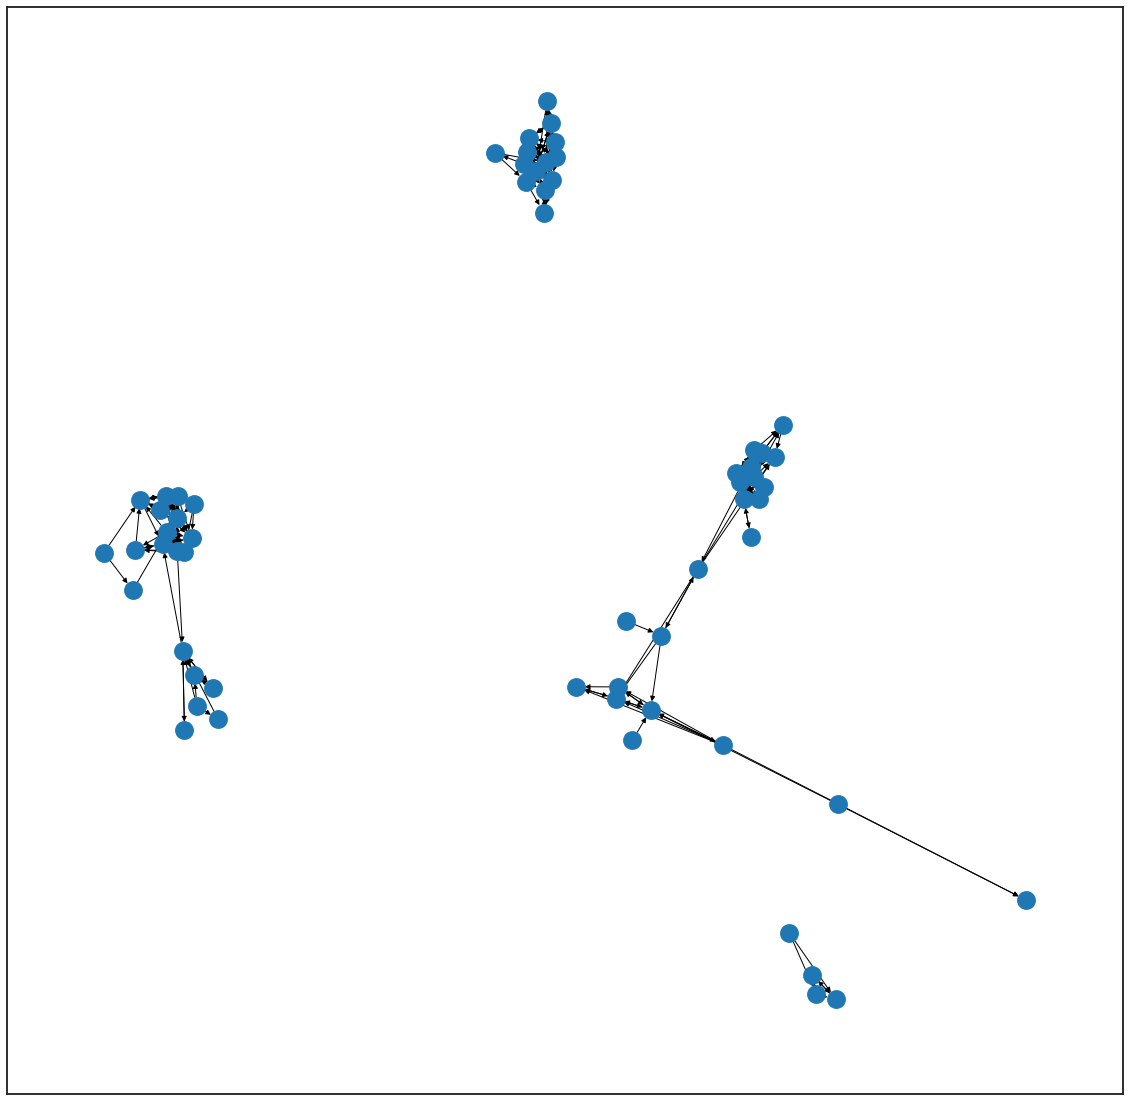

In [13]:
figure = plt.subplots(figsize = (20,20))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos,with_labels=False)

## Summary statistics

### Avatars

Relationship between indegree and outdegree

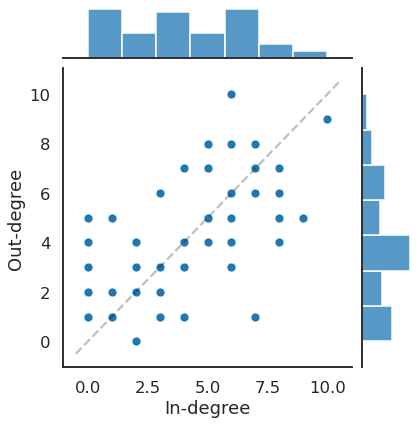

In [14]:
# get in- and out-degree of each avatar
in_df = pd.DataFrame(list(G.in_degree()), columns=['avatar', 'in'])
out_df = pd.DataFrame(list(G.out_degree()), columns=['avatar', 'out'])
connect_df = in_df.merge(out_df, on='avatar')
connect_df['influence'] = np.where(connect_df['out'] == connect_df['in'], 'equal',
                                  np.where(connect_df['out'] > connect_df['in'], 'greater', 'less'))

# color palette
# influence_colors = {'equal': "#a1a1a1", 'less': "#db3721", 'greater': "#5eb9ff"}
g = sns.jointplot(data=connect_df, x='in', y='out')
g.set_axis_labels(xlabel='In-degree', ylabel='Out-degree')

# diagonal line
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, '--k', alpha=0.25)
#g.ax_joint.set(xticks = np.linspace(0, 10, 6).astype(int))

### Objects

Load object data

In [15]:
from ohol_objects import obj_name
print(obj_name(33))

Stone


Which items are most commonly shared?

In [16]:
# Retrieve object IDs from edge list
shared_objs = [G[e[0]][e[1]]['shared'] for e in G.edges()]
shared_objs = [obj for sublist in shared_objs for obj in sublist]
shared_objs = pd.DataFrame([int_extract('^[0-9]+|(?<=^f)[0-9]+', obj) for obj in shared_objs], columns=['object_id'])

# Count instances of each object
shared_objs['count'] = 1
shared_objs = shared_objs.groupby('object_id').agg({'count': 'sum'}).reset_index()

# Sort by frequency
shared_objs['frequency'] = shared_objs['count']/np.sum(shared_objs['count'])
shared_objs = shared_objs.sort_values(by='frequency', ascending=False).reset_index(drop=True)

# Pretty-print names
top_objs = shared_objs.head(25)
top_objs['name'] = top_objs['object_id'].apply(obj_name)
top_objs

/n/home15/nvelezalicea/.conda/envs/ohol_py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,object_id,count,frequency,name
0,391,33,0.063218,Domestic Gooseberry Bush
1,235,29,0.055556,Clay Bowl - empty
2,292,23,0.044061,Basket
3,1101,18,0.034483,Fertile Soil Pile
4,1316,17,0.032567,Stack of Firewood
5,1135,17,0.032567,Empty Domestic Gooseberry Bush
6,1099,13,0.024904,Partial Bucket of Water
7,346,12,0.022989,Large Slow Fire
8,34,10,0.019157,Sharp Stone
9,33,9,0.017241,Stone


## Families

Load family labels:

In [17]:
family_df = pd.read_csv('../2_demographics/outputs/family_playerID.csv')
family_df.head()

,avatar,family
0,4109234,time-1617694919_eve-4109214_name-(missing)
1,4109230,time-1617694919_eve-4109214_name-(missing)
2,4109225,time-1617694919_eve-4109214_name-(missing)
3,4109222,time-1617694919_eve-4109214_name-(missing)
4,4109217,time-1617694919_eve-4109214_name-(missing)


Get family for each player in the current subset:

In [18]:
node_families = pd.DataFrame({'avatar': list(G.nodes())})
node_families = node_families.merge(family_df, on='avatar')
node_families.head()

# Helper: Get family label
def get_family(avatar):
        return node_families[node_families.avatar == avatar].iloc[0]['family']

Get pairwise distances between nodes:

In [19]:
distances = nx.all_pairs_dijkstra_path_length(G)
distances = list(distances)
print(distances[0])

(2406070, {2406070: 0, 2406128: 1, 2406089: 1, 2406044: 1, 2406023: 1, 2406030: 1, 2406114: 2, 2406119: 2, 2406137: 2, 2406157: 2, 2406100: 2, 2406139: 3})


Assemble into dataframe:

In [20]:
distances_list = []
for a_i, dict_i in distances:
    for a_j, w in dict_i.items():
        distances_list.append((a_i, a_j, w))
distance_df = pd.DataFrame(distances_list, columns=['avatar_i', 'avatar_j', 'distance'])

# add family labels
distance_df = (
    distance_df.merge(node_families, left_on='avatar_i', right_on='avatar')
    .rename(columns={'family': 'family_i'})
    .merge(node_families, left_on='avatar_j', right_on='avatar')
    .rename(columns={'family': 'family_j'})
)
distance_df['kin'] = np.where(distance_df.family_i == distance_df.family_j, 'Kin', 'Non-kin')
distance_df = distance_df[distance_df.avatar_i != distance_df.avatar_j]
distance_df.head()

,avatar_i,avatar_j,distance,avatar_x,family_i,avatar_y,family_j,kin
1,2406114,2406070,2,2406114,time-1576186242_eve-2404779_name-CHICOSKY,2406070,time-1576186242_eve-2404779_name-CHICOSKY,Kin
2,2406089,2406070,5,2406089,time-1576186242_eve-2404779_name-CHICOSKY,2406070,time-1576186242_eve-2404779_name-CHICOSKY,Kin
3,2406139,2406070,2,2406139,time-1576186242_eve-2404779_name-CHICOSKY,2406070,time-1576186242_eve-2404779_name-CHICOSKY,Kin
4,2406044,2406070,1,2406044,time-1576186242_eve-2404779_name-CHICOSKY,2406070,time-1576186242_eve-2404779_name-CHICOSKY,Kin
5,2406128,2406070,1,2406128,time-1576186242_eve-2404779_name-CHICOSKY,2406070,time-1576186242_eve-2404779_name-CHICOSKY,Kin


Mean graph distance to kin and non-kin:

In [21]:
distance_summ = distance_df.groupby(['avatar_i', 'kin'])['distance'].agg('mean').reset_index()
distance_summ.head()

,avatar_i,kin,distance
0,2405987,Kin,2.384615
1,2405990,Kin,4.333333
2,2405990,Non-kin,6.333333
3,2405992,Kin,2.900000
4,2405992,Non-kin,1.750000


<AxesSubplot:xlabel='kin', ylabel='distance'>

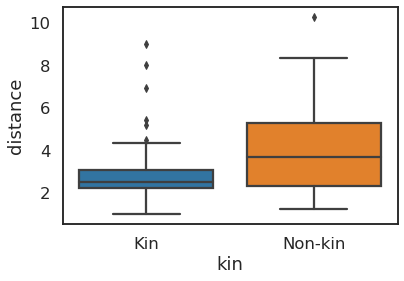

In [22]:
sns.boxplot(data=distance_summ, x='kin', y='distance')